In [1]:
%matplotlib widget
import numpy as np
import os
from nexusformat import nexus
from ipyfilechooser import FileChooser
from hdr_import import HDRFile
from matplotlib.colors import LogNorm
from scipy.ndimage import fourier_shift
import skimage
from skimage.registration import phase_cross_correlation

from functions import clean_images, import_images, plot_stack, align_images, i_bg_mean, plot_stack_roi, get_roi_intensities, line_intensity, ROIs_select, Nexus_File_Save
import matplotlib.pyplot as plt
%matplotlib widget
from IPython.display import display, clear_output
from ipywidgets import widgets, interact
import cv2

import h5py
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Rectangle

import ipywidgets as widgets
from ipywidgets import interact, widgets, Button, VBox, HBox, Output

from skimage import feature, transform, filters, io
from skimage.color import rgb2gray

from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.feature import corner_harris, corner_peaks, match_descriptors, ORB

from h5glance import H5Glance

cleaned_images, aligned_images = [], []

#debug_output = widgets.Output()

In [2]:
plt.rcParams['font.size'] = 14  # Sets the default font size
plt.rcParams['axes.titlesize'] = 20  # Font size for titles
plt.rcParams['axes.labelsize'] = 16  # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels

<h3>Choose file path</h3>
Run the following cell and choose the folder path to the STXM energy stack.

In [3]:
file_path = '/Users/igobei/Documents/data/Selected'# enter the partial path to the data for faster navigation
#file_path = '/data/visitors/softimax/20221193'
fc = FileChooser(file_path)
display(fc)

FileChooser(path='/Users/igobei/Documents/data/Selected', filename='', title='', show_hidden=False, select_des…

In [4]:
selected_path = fc.selected_path
# selected_path = fc.selected_path + '/' + 'Max_220611011.hdr' ## for single image
selected_path

'/Users/igobei/Documents/data/Selected/Max_220612080'

In [5]:
sample_hdr = HDRFile(selected_path)

Reading hdr file: /Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080.hdr
Reading xim file(s):
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a000.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a001.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a002.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a003.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a004.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a005.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a006.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a007.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a008.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a009.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_a010.xim
/Users/igobei/Documents/data/Selected/Max_220612080/Max_220612080_

In [6]:
energies = sample_hdr.as_dict['ScanDefinition']['StackAxis']['Points'][1:]
#energies

In [7]:
sample_xim_3d = np.stack(sample_hdr.xim, axis=0)

if sample_xim_3d.ndim == 2:
    # Add a new axis at position 0 to make it 3D
    sample_xim_3d = np.expand_dims(sample_xim_3d, axis=0)
elif sample_xim_3d.ndim == 3:
    # The array is already 3D
    pass
else:
    raise ValueError("The array is neither 2D nor 3D.")

np.shape(sample_xim_3d)

(48, 220, 100)

In [8]:
def display_slice(slice_index, img_stack):
    plt.imshow(img_stack[slice_index], cmap='gray')
    plt.title(f"Slice {slice_index}")
    plt.axis('off')
    plt.show()

In [9]:
interact(lambda slice_index: display_slice(slice_index, sample_xim_3d), slice_index=(0, sample_xim_3d.shape[0] - 1))

interactive(children=(IntSlider(value=23, description='slice_index', max=47), Output()), _dom_classes=('widget…

<function __main__.<lambda>(slice_index)>

In [10]:
def replace_broken_pixels(image, lower_threshold, upper_threshold, max_iterations=5):
    corrected_image = np.copy(image)
    rows, cols = image.shape
    iteration = 0
    
    while iteration < max_iterations:
        print(f'Iteration ({iteration})')
        broken_pixels_found = False
        
        for row in range(rows):
            for col in range(cols):
                # Check if the current pixel is broken
                if corrected_image[row, col] < lower_threshold or corrected_image[row, col] > upper_threshold:
                    broken_pixels_found = True
                    print(f'Found broken pixel at ({row, col}) with intensity {image[row, col]}')
                    # Identify the neighborhood of the pixel
                    row_min = max(row - 1, 0)
                    row_max = min(row + 2, rows)
                    col_min = max(col - 1, 0)
                    col_max = min(col + 2, cols)
                    
                    # Extract the neighborhood, excluding the current pixel by masking
                    mask = np.ones((row_max - row_min, col_max - col_min), dtype=bool)
                    mask[row - row_min, col - col_min] = False
                    neighborhood = corrected_image[row_min:row_max, col_min:col_max][mask]
                    
                    # Calculate the median of the surrounding pixels
                    median_value = np.median(neighborhood)
                    print(f'The median value of surrounding pixels is {median_value}')
                    
                    # Replace the broken pixel with the median value
                    corrected_image[row, col] = median_value
        
        # If no broken pixels were found in this iteration, stop the loop
        if not broken_pixels_found:
            break
        
        iteration += 1
    return corrected_image

lower_threshold = 5
upper_threshold = 400
max_iterations = 2

corrected_images = np.array([replace_broken_pixels(img, lower_threshold, upper_threshold, max_iterations) for img in sample_xim_3d])

Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Iteration (0)
Found broken pixel at ((0, 21)) with intensity 0
The median value of surrounding pixels is 195.0
Found broken pixel at ((1, 21)) with intensity 0
The median value of surrounding pixels is 195.0
Found broken pixel at ((2, 21)) with intensity 0
The median value of surrounding pixels is 195.0
Found broken pixel at ((3, 21)) with intensity 0
The median value of surrounding pixels is 19

In [11]:
def convert_image(image):
    # Convert to float and normalize
    image = image.astype(np.float64)
    image -= image.min()  # Ensure the minimum value is 0
    image /= image.max()  # Normalize to the range [0, 1]
    return image

# Convert and normalize each image in the stack
processed_images_32bit = np.array([convert_image(img) for img in corrected_images])
interact(lambda slice_index: display_slice(slice_index, corrected_images), slice_index=(0, corrected_images.shape[0] - 1))

interactive(children=(IntSlider(value=23, description='slice_index', max=47), Output()), _dom_classes=('widget…

<function __main__.<lambda>(slice_index)>

In [12]:
def replace_with_neighbor_median(image, threshold=10):
    """
    Replace vertical lines in the image where the majority of values are below 
    a certain threshold with the median of the two neighboring columns.
    """
    h, w = image.shape
    for col in range(1, w - 1):  # Start from 1 and end at w - 1 to avoid boundary issues
        if np.mean(image[:, col] < threshold) > 0.2:  # More than 50% values are below threshold
            left_neighbor = image[:, col - 1]
            right_neighbor = image[:, col + 1]
            neighbor_median = np.median(np.vstack([left_neighbor, right_neighbor]), axis=0)
            image[:, col] = neighbor_median
    return image

In [13]:
processed_images = np.array([replace_with_neighbor_median(img, threshold=120) for img in corrected_images])

In [ ]:
# Convert and normalize each image in the stack
processed_images_32bit = np.array([convert_image(img) for img in processed_images])
interact(display_slice, slice_index=(0, processed_images_32bit.shape[0] - 1))

In [14]:
def detect_edges(image):
    # Apply edge detection (e.g., Canny)
    edges = feature.canny(image)
    return edges

def extract_features(image):
    # Initialize ORB detector
    orb = ORB(n_keypoints=200, fast_threshold=0.05)
    orb.detect_and_extract(image)
    return orb.keypoints, orb.descriptors

def align_images(images):
    num_images = len(images)
    progress_bar = IntProgress(value=0, min=0, max=num_images-1, description='Processing:')
    display(progress_bar)  # Display the progress bar

    aligned_images = [images[0]]  # The first image is considered as reference and is already aligned
    reference_keypoints, reference_descriptors = extract_features(images[0])

    for i in range(1, num_images):
        keypoints, descriptors = extract_features(images[i])

        # Match descriptors between images
        matches = match_descriptors(reference_descriptors, descriptors, cross_check=True)

        # Extract matched keypoints
        src = keypoints[matches[:, 1]]
        dst = reference_keypoints[matches[:, 0]]

        # Use RANSAC to estimate a robust projective transformation
        model, inliers = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=2)

        aligned_image = transform.warp(images[i], model.inverse)
        aligned_images.append(aligned_image)

        # Update the progress bar
        progress_bar.value += 1

    return np.array(aligned_images)

In [15]:
aligned_images = align_images(processed_images_32bit)

IntProgress(value=0, description='Processing:', max=47)

In [ ]:
interact(display_slice, slice_index=(0, aligned_images.shape[0] - 1))

In [16]:
path_feature = None
path_empty = None
path_confirmed = False

def confirm_selection(btn):
    global path_confirmed
    path_confirmed = True
    btn.description = 'Selection Confirmed'
    btn.disabled = True

def extract_integrals(images, path):
    integrals = []
    ny, nx = images[0].shape
    y, x = np.mgrid[:ny, :nx]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path.contains_points(points).reshape(ny, nx)

    for image in images:
        integral_intensity = np.sum(image[mask])
        integrals.append(integral_intensity)
    return integrals

In [17]:
debug_output = widgets.Output()

Button(description='Confirm Empty Hole Selection', style=ButtonStyle())

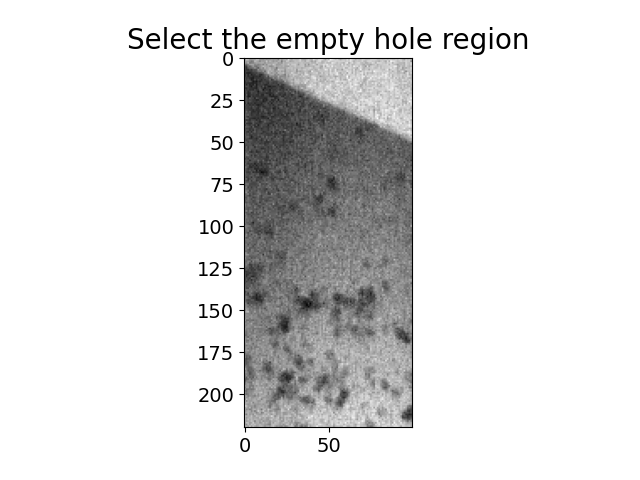

In [18]:
@debug_output.capture(clear_output=True)  # Decorator to redirect output to the upper widget
def test_onselect(verts, current_path, ax):
    print(f"Vertices selected: {verts, current_path, ax}")

@debug_output.capture(clear_output=True)
def onselect(verts, current_path, ax):
    global path_feature, path_empty
    print(f"Vertices selected: {verts, current_path, ax}")
    path = Path(verts)
    patch = PathPatch(path, edgecolor='orange', facecolor='none', lw=2)
    ax.add_patch(patch)
    ax.figure.canvas.draw()

    if current_path == 'feature':
        path_feature = path
    elif current_path == 'empty':
        path_empty = path

fig, ax = plt.subplots()
ax.imshow(aligned_images[0], cmap='gray')
plt.title('Select the empty hole region')

def confirm_selection_empty(btn):
    global path_confirmed
    path_confirmed = True
    lasso_empty.set_active(False)
    btn.description = 'Selection Confirmed'
    print(f"Selection Confirmed")
    btn.disabled = True

#display(debug_output)

#lasso_empty = LassoSelector(ax, lambda verts: onselect(verts, 'empty', ax))
lasso_empty = LassoSelector(ax, onselect=lambda verts: onselect(verts, 'empty', ax))

confirm_button_empty = widgets.Button(description="Confirm Empty Hole Selection")
confirm_button_empty.on_click(confirm_selection_empty)  # This function needs to disable the lasso and confirm selection
display(confirm_button_empty)

In [19]:
def extract_I(images, path_I):
    I_values = []
    ny, nx = images[0].shape
    y, x = np.mgrid[:ny, :nx]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path_I.contains_points(points).reshape(ny, nx)

    for image in images:
        I_intensity = np.median(image[mask])  # Using mean; you can also use sum based on your requirement
        I_values.append(I_intensity)

    plt.imshow(images[0], cmap='gray')  # Display the first image
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with some transparency
    plt.show()
    return I_values

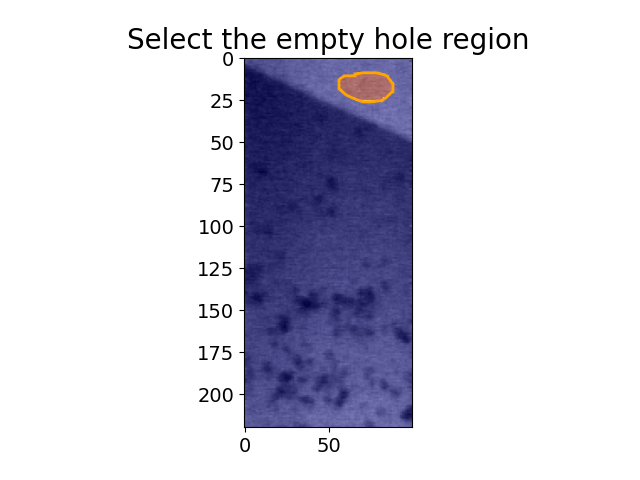

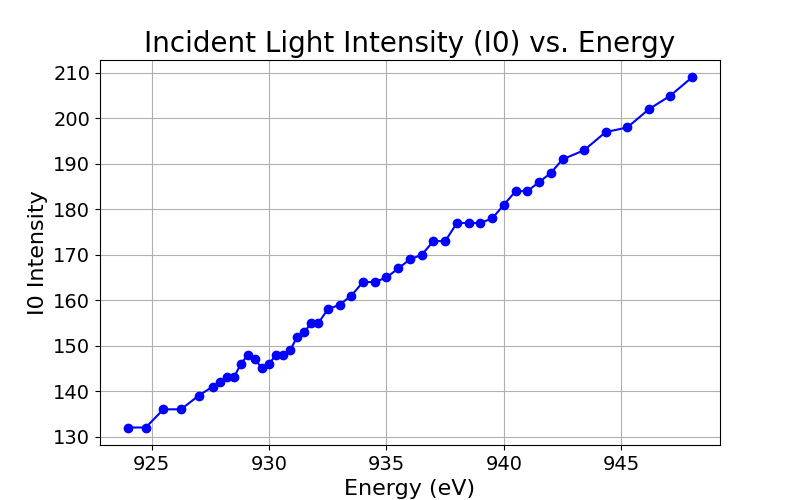

In [20]:
#I0 = extract_I0(aligned_images, path_empty)
I0 = extract_I(processed_images, path_empty)

if len(energies) != len(I0):
    print("Error: The number of energies does not match the number of I0 values.")
else:
    plt.figure(figsize=(8, 5))
    plt.plot(energies, I0, marker='o', linestyle='-', color='blue')
    plt.title('Incident Light Intensity (I0) vs. Energy')
    plt.xlabel('Energy (eV)')
    plt.ylabel('I0 Intensity')
    plt.grid(True)
    plt.show()

Button(description='Confirm Feature Selection', style=ButtonStyle())

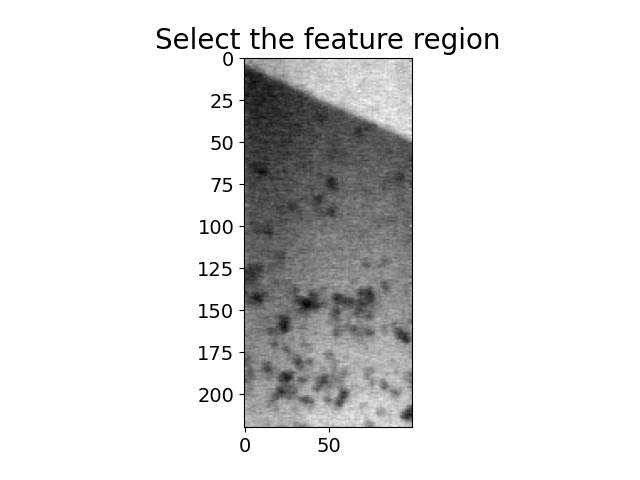

In [21]:
def confirm_selection_feature(btn):
    global path_confirmed
    path_confirmed = True
    lasso_feature.set_active(False)
    btn.description = 'Selection Confirmed'
    btn.disabled = True

fig, ax = plt.subplots()
ax.imshow(processed_images[0], cmap='gray')
plt.title('Select the feature region')

lasso_feature = LassoSelector(ax, lambda verts: onselect(verts, 'feature', ax))

confirm_button_feature = widgets.Button(description="Confirm Feature Selection")
confirm_button_feature.on_click(confirm_selection_feature)  # Adjust this function similarly
display(confirm_button_feature)

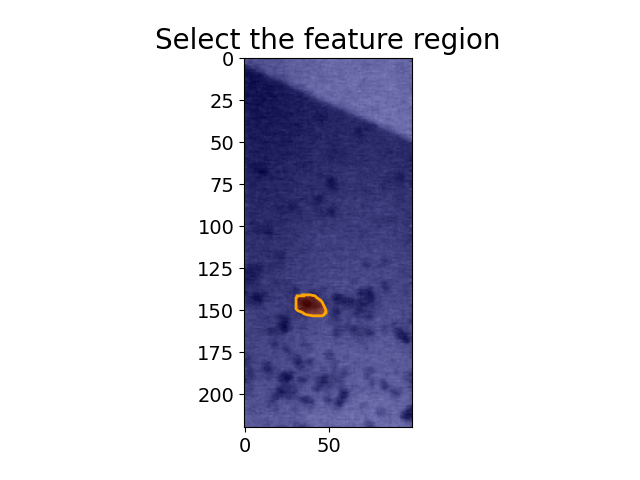

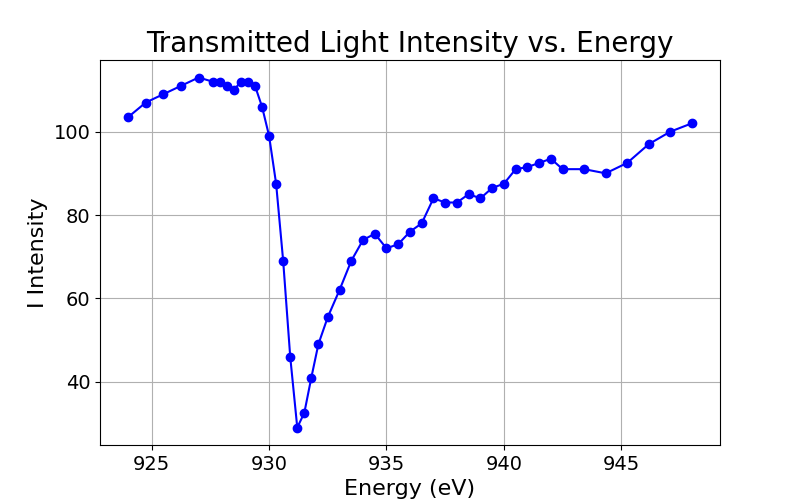

In [22]:
I = extract_I(processed_images, path_feature)

if len(energies) != len(I):
    print("Error: The number of energies does not match the number of I values.")
else:
    plt.figure(figsize=(8, 5))
    plt.plot(energies, I, marker='o', linestyle='-', color='blue')
    plt.title('Transmitted Light Intensity vs. Energy')
    plt.xlabel('Energy (eV)')
    plt.ylabel('I Intensity')
    plt.grid(True)
    plt.show()

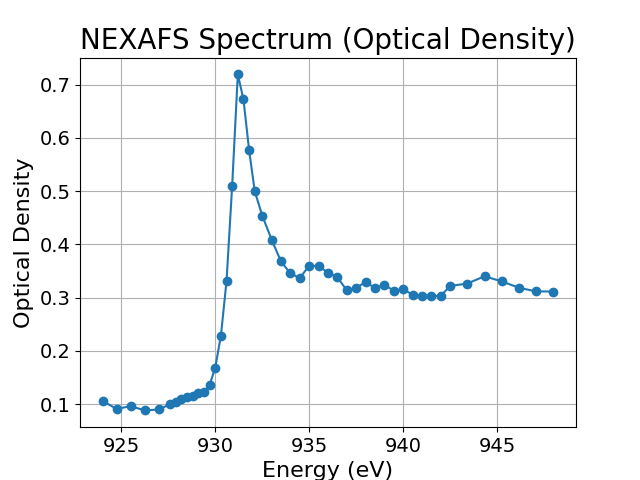

In [23]:
# Assuming 'energies', 'I', and 'I0' are defined above
def OD_calc():
    if len(energies) != len(I) or len(energies) != len(I0):
        print("Error: The length of the energies list does not match the number of images or I0 values.")
    else:
        epsilon = 1e-10
        # Ensure I and I0 values are not zero to avoid division by zero and log of zero
        I_corrected = np.clip(I, epsilon, None)
        I0_corrected = np.clip(I0, epsilon, None)
        
        # Calculate optical density using the corrected I and I0 arrays
        optical_density = np.log10(I0_corrected / I_corrected)
        return optical_density

od = OD_calc()
# Plotting the NEXAFS spectra (as optical density vs. energy)
plt.figure()
plt.plot(energies, od, marker='o', linestyle='-')
plt.xlabel('Energy (eV)')
plt.ylabel('Optical Density')
plt.title('NEXAFS Spectrum (Optical Density)')
plt.grid(True)
plt.show()

## Image cropping

In [24]:
image_stack = aligned_images

# Output widgets to display images
original_image_output = Output()
cropped_image_output = Output()

# Display function to show image with crop area
def display_crop(x_start, x_end, y_start, y_end):
    with original_image_output:
        original_image_output.clear_output(wait=True)  # Clear the previous output
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(image_stack[0], cmap='gray')  # Displaying the first image for reference
        ax.add_patch(plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, fill=False, edgecolor='red', linewidth=2))
        plt.show()

# Function to crop the image stack and display the first cropped image
def crop_stack(b):
    x_start = x_start_slider.value
    x_end = x_end_slider.value
    y_start = y_start_slider.value
    y_end = y_end_slider.value
    cropped_stack = image_stack[:, y_start:y_end, x_start:x_end]
    
    with cropped_image_output:
        cropped_image_output.clear_output(wait=True)  # Clear the previous output
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_stack[0], cmap='gray')
        plt.title("Cropped Image")
        plt.show()


In [25]:
# Sliders for selecting crop region
x_start_slider = widgets.IntSlider(min=0, max=image_stack.shape[2]-1, step=1, value=50, description='X Start')
x_end_slider = widgets.IntSlider(min=0, max=image_stack.shape[2]-1, step=1, value=150, description='X End')
y_start_slider = widgets.IntSlider(min=0, max=image_stack.shape[1]-1, step=1, value=50, description='Y Start')
y_end_slider = widgets.IntSlider(min=0, max=image_stack.shape[1]-1, step=1, value=150, description='Y End')

# Button to perform crop
crop_button = Button(description="Crop Stack")
crop_button.on_click(crop_stack)

In [26]:
# Arrange widgets
ui = VBox([HBox([x_start_slider, x_end_slider]), HBox([y_start_slider, y_end_slider]), crop_button])

# Display UI for cropping
display(ui)
display(HBox([original_image_output, cropped_image_output]))  # Display side by side

# This line binds the interactive display function to the sliders
interact(display_crop, x_start=x_start_slider, x_end=x_end_slider, y_start=y_start_slider, y_end=y_end_slider)

interactive(children=(IntSlider(value=50, description='X Start', max=99), IntSlider(value=99, description='X E…

<function __main__.display_crop(x_start, x_end, y_start, y_end)>

## Saving spectra to NEXUS

In [27]:
def save_nexafs_to_nexus(filename, energies, optical_density, annotation, group_name='NEXAFS'):
    """
    Save NEXAFS optical density data to a NeXus (HDF5) file.

    Parameters:
    - filename: Path to the NeXus (HDF5) file.
    - energies: NumPy array of energy values.
    - optical_density: NumPy array of optical density values.
    - annotation: String, annotation to add to the data.
    - group_name: Base group name for storing entries. New entries are appended under incremental subgroups.
    """
    with h5py.File(filename, 'a') as f:  # 'a' mode to append or create
        # Determine the next available subgroup index under the base group
        base_group = f.require_group(group_name)
        subgroup_index = len(base_group)
        new_group = base_group.create_group(f'{group_name}_{subgroup_index}')

        # Save data and annotation
        new_group.create_dataset('energies', data=energies)
        new_group.create_dataset('optical_density', data=optical_density)
        new_group.attrs['annotation'] = annotation

        print(f'Data saved in {group_name}/{group_name}_{subgroup_index}')


annotation = "Electrochemically deposited Cu NPs"

save_nexafs_to_nexus('/Users/igobei/Documents/data/results/nexafs_Cu_NP_0622_Adam.nxs', energies, od, annotation)

Data saved in NEXAFS/NEXAFS_3


In [29]:
H5Glance('/Users/igobei/Documents/data/results/nexafs_Cu_NP_0622_Adam.nxs')

/Users/igobei/Documents/data/results/nexafs_Cu_NP_0622_Adam.nxs/
└NEXAFS	(4 children)

## Interactive Entry Selection and Plotting

In [30]:
@debug_output.capture(clear_output=True)
def plot_nexafs_entries(filename, entry_indices):
    """
    Plot selected NEXAFS entries from a NeXus file.

    Parameters:
    - filename: Path to the NeXus file.
    - entry_indices: List of indices of the entries to plot.
    """
    with h5py.File(filename, 'r') as f:
        plt.figure(figsize=(10, 6))
        
        # Base group name where NEXAFS entries are stored
        group_name = 'NEXAFS'
        
        for idx in entry_indices:
            subgroup_name = f'{group_name}_{idx}'
            if subgroup_name in f[group_name]:
                subgroup = f[group_name][subgroup_name]
                energies = subgroup['energies'][:]
                optical_density = subgroup['optical_density'][:]
                plt.plot(energies, optical_density, marker='o', linestyle='-', label=subgroup_name)
        
        plt.title('NEXAFS Optical Density vs. Energy')
        plt.xlabel('Energy (eV)')
        plt.ylabel('Optical Density')
        plt.legend()
        plt.grid(True)
        plt.show()

In [31]:
filename = '/Users/igobei/Documents/data/results/nexafs_Cu_NP_0622_Adam.nxs'  # Your NeXus file name

max_entries = 10  # Example max number of entries

# Widget for selecting entries
entry_selector = widgets.SelectMultiple(
    options=list(range(max_entries)),
    value=[0],  # Default value
    description='Entries',
    disabled=False
)

# Button to trigger the plot
plot_button = widgets.Button(description="Plot Selected Entries")

# Function to handle button click and plot data
@debug_output.capture(clear_output=True)
def on_plot_button_clicked(b):
    print('You have selected entry f"{entry_selector.value}"')
    selected_entries = list(entry_selector.value)
    plot_nexafs_entries(filename, selected_entries)

plot_button.on_click(on_plot_button_clicked)

# Display the widgets
debug_output.clear_output()
display(debug_output)
display(entry_selector, plot_button)

Output(outputs=({'name': 'stdout', 'text': "Vertices selected: ([(33.428571428571416, 140.71651785714283), (33…

SelectMultiple(description='Entries', index=(0,), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=(0,))

Button(description='Plot Selected Entries', style=ButtonStyle())